This tutorial will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We will assume appropriate quality-control (QC) has already been applied to the dataset (e.g., exclusion of low-quality cells and doublets). We recommend the tutorial by [Luecken & Theis](https://doi.org/10.15252/msb.20188746) as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general. 


--------------------------

Daniel comment:

^ Can now refer to the best-practices book:
https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

So, better to write this part around how these steps affect our tools specifically :)

--------------------------

Here we will focus on:
1. Normalization
2. Inter-operability between R and python. 

We demonstrate a typical workflow using the popular single-cell analysis software [scanpy](https://scanpy.readthedocs.io/en/stable/) to generate an AnnData object which can be used downstream. We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the additional examples tutorial entitled "S1_Batch_Correction".

## Preparare the object for cell-cell communication analysis

Here, I just do the basic processing as it makes sense to me to be seperate from the scoring function chapter

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import cell2cell as c2c

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reload adata object
adata = c2c.datasets.balf_covid()

#### Basic Filtering

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

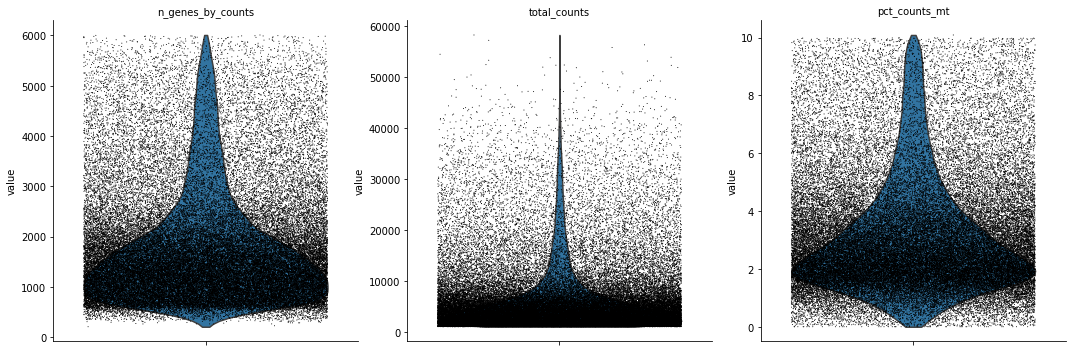

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

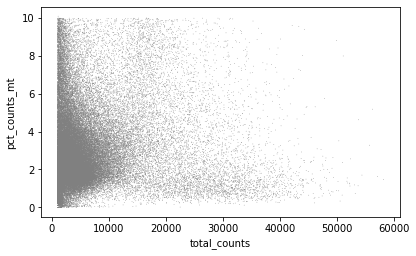

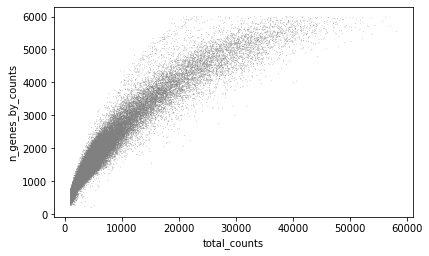

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

#### Normalize

For single-cell inference across sample and across cell types, we require the library sizes to be comparable. We can use the scanpy function `sc.pp.normalize_total` to normalize the library sizes. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream.

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy() # copy the normalized data to adata.layers["logcounts"]

#### Find Variable features

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

#### Dimensionality Reduction

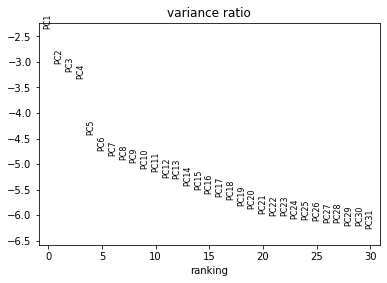

In [11]:
# pca
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
# neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
# umap
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Of course, would be better to replot the UMAP with integrated data :) - I just needed the normalized counts for the second chapter :) ##TODO

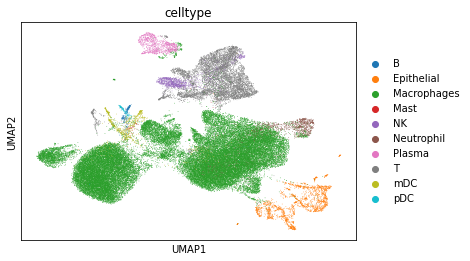

In [13]:
# plot pre-annotated cell types
sc.pl.umap(adata, color=['celltype']) ###

Save the data for downsteam analysis

In [14]:
adata.write_h5ad('../../data/processed.h5ad')